In [1]:
from IPython.display import display, clear_output
import numpy as np
import pyopencl as cl
from PIL import Image
import time
import signal

In [2]:
from skvideo.io import FFmpegWriter
from IPython.display import HTML
import base64
import io

In [3]:
from simulation import Scene

%load_ext autoreload
%autoreload 2

In [4]:
signal_done = False

def signal_handler(signal, frame):
    global signal_done
    signal_done = True

def stop_on_signal():
    global signal_done
    signal_done = False
    signal.signal(signal.SIGINT, signal_handler)

In [5]:
ctx = cl.create_some_context()

In [42]:
scene = Scene(
    ctx,
    (800, 600),
    params={
        "time_step": 0.02,
        "grid_size": 0.001,
        "pressure_steps": 64,
        "viscosity": 1e-4,
})

for i in range(20):
    x = np.random.uniform(0, scene.size[0])
    y = np.random.uniform(0, scene.size[1])
    l = min(scene.size[0], scene.size[1])
    r = np.random.uniform(0.01*l, 0.25*l)
    v = 0.25*l
    vx = np.random.uniform(-v, v)
    vy = np.random.uniform(-v, v)
    c = np.random.randint(1, 8)
    col = ((c>>0)&1,(c>>1)&1,(c>>2)&1)
    #col = (1,1,1)
    scene.draw("circle", col, (vx, vy), (x, y), r)

In [43]:
params = {
    "-vcodec": "libx264",
    "-pix_fmt": "yuv420p",
    "-profile:v": "baseline",
    "-level": "3"
}
video = FFmpegWriter("tmp.mp4", outputdict=params)
stride = int(1.0/(24*scene.params["time_step"]))
for i in range(4*24):
    for j in range(stride):
        scene.step()
    img = scene.render()
    video.writeFrame(img)
video.close()

In [ ]:
with open("tmp.mp4", "rb") as f:
    vdata = f.read()
vbase64 = base64.b64encode(vdata).decode("ascii")
HTML('<video controls width=800 src="data:video/mp4;base64,%s" type="video/mp4" >' % vbase64)

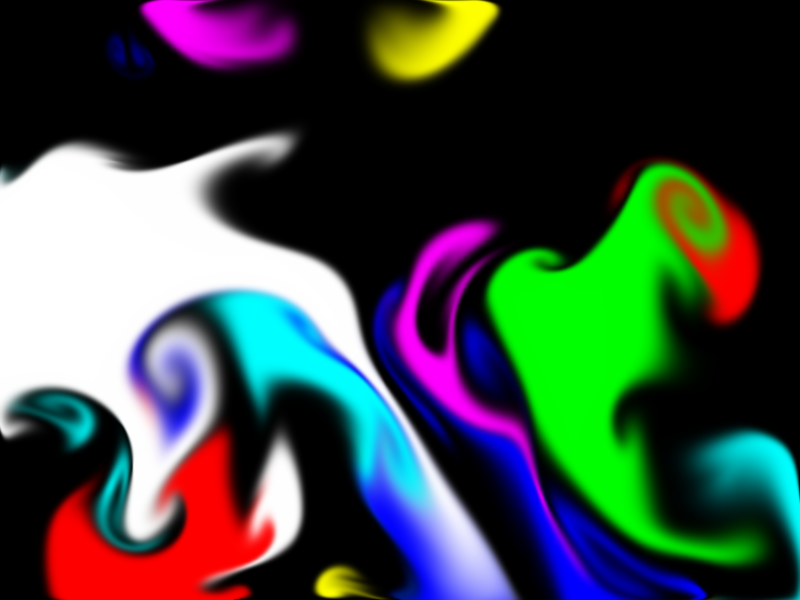

In [45]:
display(Image.fromarray(scene.render()))